# Understanding the distribution of HANDL homology scores, and the relative maginitudes of embedded RKHS vectors

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

import os, sys
sys.path.append(os.getcwd() + "/../src")

%load_ext autoreload
%autoreload 2

import networkx as nx
import numpy as np
import handl
import util
from collections import defaultdict

In [2]:
def plot(scores_and_labels, xlabel,
         xmin=0.0, 
         xmax=0.6, 
         smoothness=20., 
         font_size=12, 
         line_width=2):
    from sklearn import neighbors

    # create and save plot
    plt.figure()
    
    # create kernel density estimator
    kde = neighbors.KernelDensity(kernel='gaussian', bandwidth = xmax / smoothness)
    # need to add another dimension as required by sklearn
    # arrays passed to kde must be 2-dimensional
    X_plot = np.reshape(np.linspace(xmin, xmax, 500), (-1, 1))
    styles = ['-', '--', '-.', ':']
    for i, (xs, label) in enumerate(scores_and_labels):
        scores = np.ravel(xs) if len(xs) < 1e5 else np.random.choice(np.ravel(xs), int(1e5))
        kde.fit(np.reshape(scores, (-1, 1)))
        densities = kde.score_samples(X_plot)
        plt.plot(X_plot[:,0], np.exp(densities), lw = line_width,
                 label = label, ls=styles[i % len(styles)])
    plt.ylabel('Density', size = font_size)
    plt.xlabel(xlabel, size = font_size)
    plt.legend(loc='best', fontsize = font_size)

In [3]:
sp_ppi_path = "../data/ppi/biogrid/sp/sp-biogrid.v3.4.157-ppi-std.tsv" 
sc_ppi_path = "../data/ppi/biogrid/sc/sc-biogrid.v3.4.157-ppi-std.tsv" 
sc_G = util.simple_two_core(nx.read_edgelist(sc_ppi_path, encoding='ascii'), verbose=False)
sp_G = util.simple_two_core(nx.read_edgelist(sp_ppi_path, encoding='ascii'), verbose=False)

In [4]:
homologs_path = "../data/homologs/sc-sp/sp-sc-homologs.txt" 

In [5]:
source_G, target_G = sp_G, sc_G
source_nodes, target_nodes = sorted(source_G.nodes()), sorted(target_G.nodes())
homologs = handl.homologs_in_graphs(source_G, target_G, util.read_homolog_list(homologs_path))
source_n2i = dict((n,i) for i, n in enumerate(source_nodes))
target_n2i = dict((n,i) for i, n in enumerate(target_nodes))

source_L = nx.laplacian_matrix(source_G, sorted(source_G.nodes())).todense()
target_L = nx.laplacian_matrix(target_G, sorted(target_G.nodes())).todense()


A node of the condition numbers with $\lambda=0.05$

In [6]:
print('Source laplacian condition number', np.linalg.cond((np.eye(len(source_L)) - 0.005 * source_L)))
print('Target  laplacian condition number', np.linalg.cond(np.eye(len(target_L)) - 0.0005 * target_L))

Source laplacian condition number 33.506611680545454
Target  laplacian condition number 52.6153691051292


### Perform HANDL embedding

In [35]:
source_D = handl.regularized_laplacian(source_G, source_nodes, 0.05)
target_D = handl.regularized_laplacian(target_G, target_nodes, 0.05)

source_C = handl.rkhs_factor(source_D)
target_C = handl.rkhs_factor(target_D)

n_landmarks = 400
homolog_idxs = [(source_n2i[s], target_n2i[t]) for (s,t) in homologs]
landmark_idxs = homolog_idxs[:400]
source_landmark_idxs, target_landmark_idxs = zip(*landmark_idxs)
target_D[np.arange(len(target_D)), np.arange(len(target_D))]= 0
source_C, target_C_hat = handl.handl_embed_matrices(source_C, target_D, landmark_idxs)

### Distribution of rowsums of source and target regularized laplacians

In [8]:
source_D_rowsums = np.sum(source_D, axis=1)
target_D_rowsums = np.sum(target_D, axis=1)
source_D_colsums = np.sum(source_D, axis=1)
target_D_colsums = np.sum(target_D, axis=1)

def mmm(arr):
    return np.min(arr), np.mean(arr), np.max(arr)

print('Source D, row-sum (min, mean, max)', mmm(source_D_rowsums))
print('Source D, column-sum (min, mean, max)', mmm(source_D_colsums))
print('Target D, row-sum (min, mean, max)', mmm(target_D_rowsums))
print('Target D, column-sum (min, mean, max)', mmm(target_D_colsums))

Source D, row-sum (min, mean, max) (0.9999999999999981, 1.0, 1.0000000000000018)
Source D, column-sum (min, mean, max) (0.9999999999999981, 1.0, 1.0000000000000018)
Target D, row-sum (min, mean, max) (0.9999999999999963, 1.0, 1.0000000000000024)
Target D, column-sum (min, mean, max) (0.9999999999999963, 1.0, 1.0000000000000024)


As expected, rows and columns of regularied laplacieans sum to 1...

Now lets look at $D_{12}$

In [36]:
D_12 = source_C @ target_C_hat.T

In [10]:
D_12_rowsums = np.sum(D_12, axis=1)
D_12_colsums = np.sum(D_12, axis=0)

print('D12 shape:', D_12.shape)
print('D12, row-sum (min, mean, max):', mmm(D_12_rowsums))
print('D12, column-sum (min, mean, max):', mmm(D_12_colsums))

D12 shape: (1865, 5609)
D12, row-sum (min, mean, max): (6.439039580663055e-07, 0.22021631571916758, 1.0000000000000075)
D12, column-sum (min, mean, max): (7.92190631305398e-08, 0.07322221943595071, 1.3137141089014222)


In [37]:
D_12_landmark_rows = D_12[source_landmark_idxs, :]
D_12_landmark_cols = D_12[:, target_landmark_idxs]
print('D_12 landmark rows shape', D_12_landmark_rows.shape)
print('D_12 landmark cols shape', D_12_landmark_cols.shape)


def non_landmark_idxs(n, landmark_idxs):
    return [i for i in range(n) if i not in set(landmark_idxs)]

source_non_landmark_idxs = non_landmark_idxs(len(source_D), source_landmark_idxs)
target_non_landmark_idxs = non_landmark_idxs(len(target_D), target_landmark_idxs)

D_12_non_landmark_rows = D_12[source_non_landmark_idxs, :]
D_12_non_landmark_cols = D_12[:, target_non_landmark_idxs]

print('D_12 non landmark rows shape', D_12_non_landmark_rows.shape)
print('D_12 non landmark cols shape', D_12_non_landmark_cols.shape)

D_12 landmark rows shape (400, 5609)
D_12 landmark cols shape (1865, 400)
D_12 non landmark rows shape (1465, 5609)
D_12 non landmark cols shape (1865, 5209)


In [38]:
D_12_landmark_rowsums = np.sum(D_12_landmark_rows, axis=1)
D_12_non_landmark_rowsums = np.sum(D_12_non_landmark_rows, axis=1)
print('D_12 landmark rowsum (min, mean, max)', mmm(D_12_landmark_rowsums))
print('D_12 non landmark rowsum (min, mean, max)', mmm(D_12_non_landmark_rowsums))


D_12 landmark rowsum (min, mean, max) (0.0899060805714223, 0.664779115601386, 0.992045843580653)
D_12 non landmark rowsum (min, mean, max) (0.0001985358939233147, 0.043436334636615594, 0.3735272420851097)


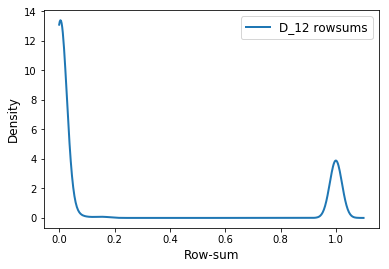

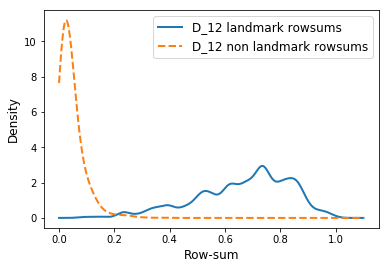

In [39]:
plot([(D_12_rowsums, 'D_12 rowsums'),],'Row-sum', xmin=0.0, xmax=1.1, smoothness=50)
plot([(D_12_landmark_rowsums, 'D_12 landmark rowsums'),
      (D_12_non_landmark_rowsums, 'D_12 non landmark rowsums')],
     'Row-sum', xmin=0.0, xmax=1.1, smoothness=50)

For some reason, the rowsums are bimodal and the distributions for landmarks and non-andmarks.

Let's repeat for column sums...

D_12 landmark column sum (min, mean, max) (0.008858191857546518, 0.10284842152401882, 0.183372613590627)
D_12 non landmark column sum (min, mean, max) (0.002400916254039546, 0.055366962540523854, 0.18055689560509278)


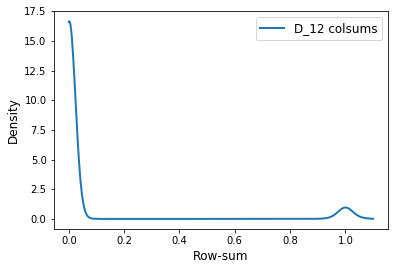

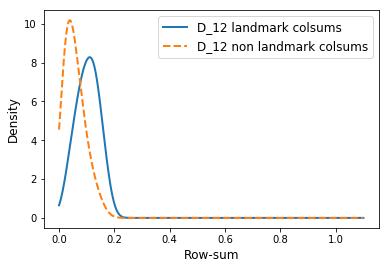

In [40]:
D_12_landmark_colsums = np.sum(D_12_landmark_cols, axis=0)
D_12_non_landmark_colsums = np.sum(D_12_non_landmark_cols, axis=0)
print('D_12 landmark column sum (min, mean, max)', mmm(D_12_landmark_colsums))
print('D_12 non landmark column sum (min, mean, max)', mmm(D_12_non_landmark_colsums))
plot([(D_12_colsums, 'D_12 colsums'),],'Row-sum', xmin=0.0, xmax=1.1, smoothness=50)
plot([(D_12_landmark_colsums, 'D_12 landmark colsums'),
      (D_12_non_landmark_colsums, 'D_12 non landmark colsums')],
     'Row-sum', xmin=0.0, xmax=1.1, smoothness=50)

### Conclusion
landmark rows are like kernels, non-landmark rows are not...

Notice $C_1 \cdot \hat{C_2} = D_{12}$
```
+----------+   +-----+    +---------------------+
|S_1 : S_2 | * | T_1 |    | S_1*T_1 : S_2 * T_1 |
+----------+   | ... |  = |.....................|
               | T_2 |    | S_1*T_2 : S_2 * T_2 |
               + ----+    +---------------------+
```

*Q* : so why do our dissimilarity plots work?

*A* : Homologs do have higher scores than other scores in S_2 * T_2 (the bottom right of D_12)

In [41]:
def separate_scores(scores, landmark_pair_idxs, homolog_pair_idxs):
    ''' 
    Separate scores into the following 5 categories:
        1. Landmark - Landmark pair scores
        2. Off diagonal entries in the landmark-landmark submatrix
        3. Landmark- (non-landmark) entries in rows and columns that correspond
           to one landmark
        4. Homolog-homolog pairs
        5. Other pairs
    '''
    source_landmark_idxs, target_landmark_idxs = zip(*landmark_pair_idxs)
    source_homolog_idxs, target_homolog_idxs = zip(*homolog_pair_idxs)
    landmark_mask = np.zeros_like(scores, dtype=bool)
    
    source_landmark_target_all_mask = np.zeros_like(scores, dtype=bool)
    source_landmark_target_all_mask[source_landmark_idxs, :]  = True
    source_all_target_landmark_mask = np.zeros_like(scores, dtype=bool)
    source_all_target_landmark_mask[:, target_landmark_idxs]  = True
    landmark_landmark_mask = np.zeros_like(scores, dtype=bool) 
    landmark_landmark_mask[source_landmark_idxs, target_landmark_idxs] = True
    
    # Obtain landmark-landmark pairs
    L_L_diag_scores = scores[source_landmark_idxs, target_landmark_idxs]
    
    # Obtain landmark-landmark off diag pairs
    L_L_off_diag_mask = np.logical_and(source_landmark_target_all_mask, source_all_target_landmark_mask)
    L_L_off_diag_mask &= ~landmark_landmark_mask
    L_L_off_diag_scores = scores[L_L_off_diag_mask]
    
    # Landmark - Non-landmark pairs
    LX_mask = source_landmark_target_all_mask & ~np.logical_and(source_landmark_target_all_mask, source_all_target_landmark_mask)
    LX_scores = scores[LX_mask]
    
    XL_mask = source_all_target_landmark_mask & ~np.logical_and(source_landmark_target_all_mask, source_all_target_landmark_mask)
    XL_scores = scores[XL_mask]
    
    # Hom - Hom pairs
    H_H_mask = np.zeros_like(scores, dtype=bool)
    H_H_mask[source_homolog_idxs, target_homolog_idxs] = True
    H_H_mask[source_landmark_idxs, target_landmark_idxs] = False
    H_H_scores = scores[H_H_mask]
    
    # Obtain other scores
    other_mask = np.ones_like(scores, dtype=np.bool)
    other_mask &= ~(source_landmark_target_all_mask | source_all_target_landmark_mask | H_H_mask )
    other_scores = scores[other_mask] 

    return L_L_diag_scores,\
           L_L_off_diag_scores,\
           LX_scores,\
           XL_scores,\
           H_H_scores,\
            other_scores

In [42]:
separated_D_12_raw_scores = separate_scores(D_12, landmark_idxs, homolog_idxs)
D_12_raw_plots = list(zip(separated_D_12_raw_scores,
                         ['landmark-landmark', 'S1*T1', 'S2*T1', 'S1*T2', 'homolog-homolog', 'S2*T2']))
print('D_12 elementwise (min, mean, max)', mmm(D_12))

D_12 elementwise (min, mean, max) (-2.0491421059976034e-17, 3.150297769079431e-05, 0.031201511229520196)


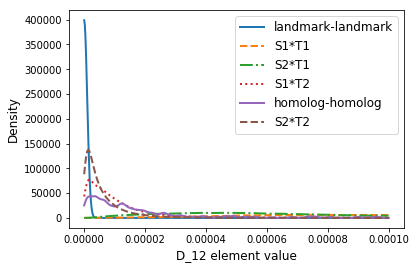

In [45]:
plot(D_12_raw_plots, xlabel='D_12 element value', xmin=0, xmax=1e-4, smoothness=100)

Though hard to interpret, we actually know what is going on... landmark-landmark pairs are close in projection so the inner products are far from zero. Other inner products are small for two possible reasons:

1. Inner products in $\mathcal{R}^{6000}$ are small because vectors are nearly orthogonal in high dimensions
2. The actual magnitudes of the rkhs is small (we'll confirm this later)

But still... why do our dissimilarity plots look nice and why does kfs work? We can zoom in...

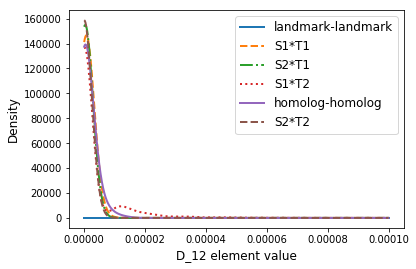

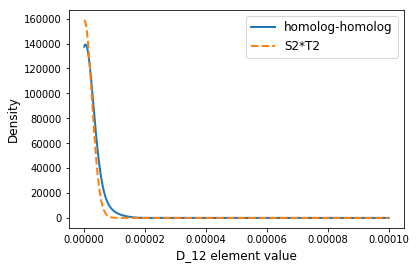

In [18]:
plot(D_12_raw_plots, xlabel='D_12 element value', xmin=0, xmax=0.0001, smoothness=40)
plot(D_12_raw_plots[-2:], xlabel='D_12 element value', xmin=0, xmax=0.0001, smoothness=40)

Homologs are still, on average, more similar than non-homologs in the right in the `[L:M]` region of D_12

We should investigate the magnitudes of rkhs vectors...

In [19]:
source_C_row_mags = (np.linalg.norm(source_C, ord=2, axis=1))
target_C_row_mags = (np.linalg.norm(target_C, ord=2, axis=1))
target_C_hat_row_mags = (np.linalg.norm(target_C_hat, ord=2, axis=1))

print(len(source_C_row_mags), len(target_C_row_mags), len(target_C_hat_row_mags))

1865 5609 5609


In [20]:
print('source_C_row_mags (min, mean, max):', mmm(source_C_row_mags))
print('target_C_row_mags (min, mean, max):', mmm(target_C_row_mags))
print('target_C_hat_row_mags (min, mean, max):', mmm(target_C_hat_row_mags))

source_C_row_mags (min, mean, max): (0.6574371080734505, 0.9815499793466935, 0.9950616378022349)
target_C_row_mags (min, mean, max): (0.6312258433515638, 0.9920927084682118, 0.9995006211884376)
target_C_hat_row_mags (min, mean, max): (5.16936874877091e-09, 0.07084640366034492, 1.1709459270556895)


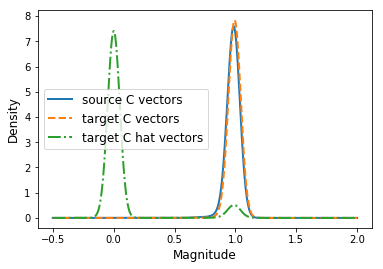

In [21]:
plot([(source_C_row_mags, 'source C vectors'),
      (target_C_row_mags, 'target C vectors'),
      (target_C_hat_row_mags, 'target C hat vectors')],
      'Magnitude', xmin=-0.5, xmax=2, smoothness=40)

Lets separate out landmark and non landmark handl embeddings

In [22]:
target_C_hat_landmark_rows = target_C_hat[target_landmark_idxs, :]
target_C_hat_non_landmark_rows = target_C_hat[target_non_landmark_idxs, :]

In [23]:
target_C_hat_landmark_row_mags = np.linalg.norm(target_C_hat_landmark_rows, axis=1)
target_C_hat_non_landmark_row_mags = np.linalg.norm(target_C_hat_non_landmark_rows, axis=1)

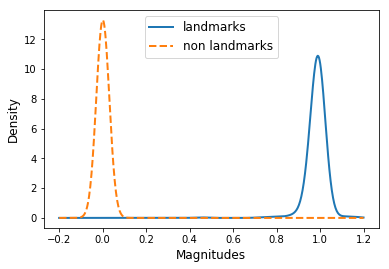

In [24]:
plot([(target_C_hat_landmark_row_mags, "landmarks"),
      (target_C_hat_non_landmark_row_mags, 'non landmarks')],
     'Magnitudes', xmin=-0.2, xmax=1.2, smoothness=40)

In [25]:
target_C_hat_normalized = target_C_hat / target_C_hat_row_mags.reshape(-1,1)

In [26]:
target_C_hat_normalized_mags = np.linalg.norm(target_C_hat_normalized, axis=1)

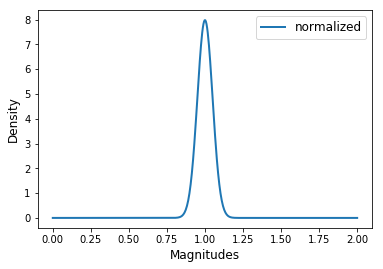

In [27]:
plot([(target_C_hat_normalized_mags, "normalized")],
     'Magnitudes', xmin=0, xmax=2, smoothness=40)

In [28]:
D_12_normalized = source_C @ target_C_hat_normalized.T

In [29]:
D_12_N_separated = separate_scores(D_12_normalized, landmark_idxs, homolog_idxs)

In [30]:
D_12_N_plots = list(zip(D_12_N_separated,
                         ['landmark-landmark', 'S1*T1', 'S2*T1', 'S1*T2', 'homolog-homolog', 'S2*T2']))
print('normalized, (min, mean, max)', mmm(D_12_normalized))

normalized, (min, mean, max) (3.401098847000128e-14, 0.0021098935916018715, 0.9950613871729379)


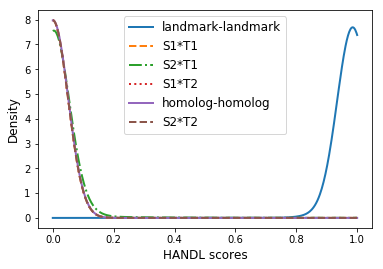

In [31]:
plot(D_12_N_plots, 'HANDL scores', xmin=0, xmax = 1)

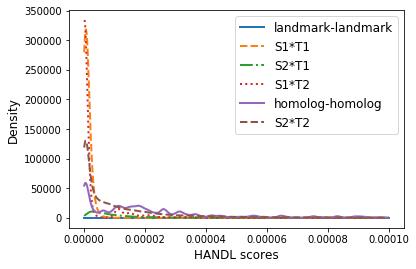

In [34]:
plot(D_12_N_plots, 'HANDL scores', xmin=0, xmax = 1e-4, smoothness = 100)